
# Instructions: 
##### To just produce final graph(s) as seen in the paper, run cells in "Section 1: Setup" and "Section 3: Final Graph(s)" section only, ignore the "Section 2: Simulations "
##### To run the simulations and produce your own data, run the whole notebook

### Section 1: Setup

In [64]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.linalg
import matplotlib
import csv
import random
from itertools import groupby
import collections
from scipy.special import gamma, factorial
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
###########################################

plt.style.use("seaborn-v0_8-white")
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 5

##############################################
def migration_matrix(length, migration_rate):
    first_col = np.zeros(length)
    first_col[1] = migration_rate
    first_col[-1] = migration_rate
    result = scipy.linalg.circulant(first_col)
    return result

##############################################################
Deme_density = 20
L = 20000 #the number of demes 
deme_sample_size = Deme_density #deme sample size 
trials = 50 #number of trials
m = 0.5 #migration rate
total_sample_size = L * deme_sample_size # total sample size
matrix = migration_matrix(L, m/2)

population_configurations = L * [msprime.PopulationConfiguration(sample_size=deme_sample_size)]

print("we want 1 <<< m*deme_density <<< number of demes to keep continous structure")
print("1 <<< ",m*Deme_density," <<< ",L )
    

we want 1 <<< m*deme_density <<< number of demes to keep continous structure
1 <<<  10.0  <<<  20000


In [65]:
Effective_pop = L**2 / (2 * m * np.pi**2)
print("The effective population size via Maruyama equation is: ", Effective_pop)
real_pop = L*Deme_density
print("The real population size is", real_pop)

# Since we're using branch lengths, the mutation rate is 1
Theta_eff = 4 * Effective_pop
Theta_real = 4 * real_pop


The effective population size via Maruyama equation is:  40528473.45693511
The real population size is 400000


### Section 2: Simulations 

In [ ]:
afs2 = []

for i in range(trials):
    ts = msprime.simulate(Ne=Deme_density, population_configurations=population_configurations, migration_matrix=matrix,record_provenance=False)

    afs1 = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
    
    afs2.append(afs1)
    
    print("iteration",i)
    
afs = np.mean(afs2, 0)

In [ ]:
def smooth(x, threshold, rescale):
    return [np.mean(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]

transition_freq=max(Deme_density,(m*Deme_density**2))/total_sample_size


In [ ]:
def smooth_sem(x, threshold, rescale):
        return [stats.sem(x[max(i - (rescale * i) // threshold, 0) : min(i + 1 + (rescale * i) // threshold, len(x))]) for i in range(len(x))]


In [ ]:
thresh=1000
scale=300
err=np.array(smooth_sem(afs[1:], threshold=thresh, rescale=scale))

#### Producing voter model prediction

In [ ]:
frequencies=np.arange(1, total_sample_size+1)/(total_sample_size+1)
SNPs = smooth(afs[1:], threshold=1000, rescale=200)
data_x=[]
data_y=[]
for i in range(len(frequencies)):
    if frequencies[i]>=transition_freq:
        data_x.append(frequencies[i])
        data_y.append(SNPs[i])

In [ ]:
f=L*np.array(data_x)
u=1
fit=(u*L)/(m*Deme_density) * (1-np.array(data_x))

#### Saving data 

In [ ]:
AF_xpoints = np.arange(1,total_sample_size+1)/(total_sample_size)


Maruyama_effective_ydata = Theta_eff / np.arange(1,total_sample_size+1)


Maruyama_census_ydata = Theta_real / np.arange(1,total_sample_size+1)


Simulated_data = smooth(afs, threshold=thresh, rescale=scale)
np.savetxt('Simulated_data_mrhogreat.csv', Simulated_data , delimiter=',')

error_data =np.array(smooth_sem(afs, threshold=thresh, rescale=scale))
np.savetxt('Simulated_data_mrhogreat_error.csv', error_data , delimiter=',')

np.savetxt('Voter_x_data.csv', data_x, delimiter=',')

np.savetxt('Voter_y_data.csv', voter, delimiter=',')


transition_frequency=max(Deme_density,(m*Deme_density**2))/total_sample_size


### Section 3: Final Graph(s)

In [67]:
AF_xpoints = np.arange(1,total_sample_size+1)/(total_sample_size)


Maruyama_effective_ydata = Theta_eff / np.arange(1,total_sample_size+1)


Maruyama_census_ydata = Theta_real / np.arange(1,total_sample_size+1)

Simulated_data_read = np.array(pd.read_csv('Simulated_data_mrhogreat.csv'))

error_data_read= np.array(pd.read_csv('Simulated_data_mrhogreat_error.csv'))

voter_x_read=np.array(pd.read_csv('voter_x_data.csv'))

voter_y_read=np.array(pd.read_csv('voter_y_data.csv'))

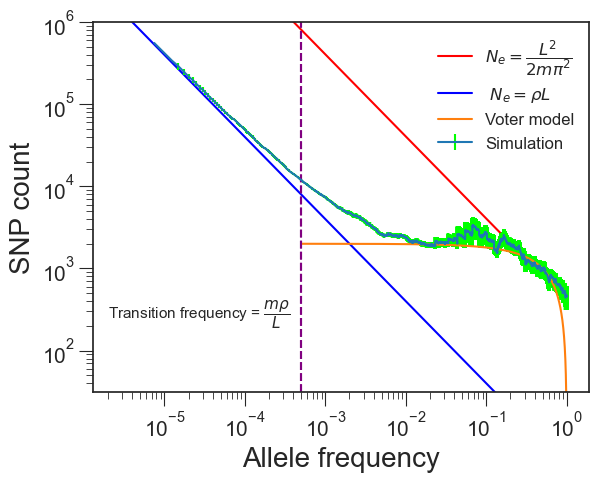

In [77]:
err=error_data_read.flatten()
transition_freq=max(Deme_density,(m*Deme_density**2))/total_sample_size

plt.loglog(AF_xpoints, Maruyama_effective_ydata, color="red", label=r"$N_e=\dfrac{L^2}{2m\pi^2}$")
plt.loglog(AF_xpoints,Maruyama_census_ydata, color="blue", label=r" $N_e=\rho L$")
plt.errorbar(AF_xpoints[2:], Simulated_data_read.flatten() , yerr=err, ecolor="lime", label="Simulation")

plt.axvline(transition_freq,color='purple', linestyle = '--')
plt.text(0.000002,250,r"Transition frequency = $\dfrac{m\rho}{L}$",fontsize='11')

plt.loglog(voter_x_read,voter_y_read, label='Voter model')
plt.axvline(transition_freq,color='purple',linestyle='dashed' )
#plt.axhline(4*L/(m*Deme_density), color='green',linestyle='dashed', label=r"$\dfrac{4L}{m\rho}$")
#plt.axhline((L/(m*Deme_density))-1,color='maroon', linestyle='dashed', label=r"$\dfrac{L}{m\rho}-1$")
plt.legend(loc="upper right", prop={'size': 12})
plt.xlabel("Allele frequency")
plt.ylabel("SNP count")
plt.ylim(10**1.5,10**6)
plt.savefig("1d_mrhogreat.pdf", bbox_inches = "tight")